# Energy data hack 
Challenge 1 : Interception des ondes radios sur les capteurs d’énergies


## Partie 2 : Entrainement des modèles  

# Membres : 
- Maxence Brugères (Telecom Paris & Sciences Po)
- Clément Bernard (Telecom Paris & Polytechnique Montréal)
- Inès Benito (ENSTA Bretagne)
- Corentin Lestrat (ENSTA BRETAGNE)



![picture](https://github.com/clementbernardd/hackaton_ondes/raw/main/images/logo_hackaton.png)

# Importations of data and models 

In [1]:
# Obtention des données 
!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/Hackaton.zip
!unzip  Hackaton.zip
!rm Hackaton.zip

!mkdir models_stack
!mkdir models_noise
!mkdir models 

import sys
sys.path.append('/content/Hackaton/python')
sys.path.append('/content/python')
from read_pics import  * 


import os 
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn 
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import cross_validate, GridSearchCV


# Device to use : either gpu or cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import pickle 

def save_obj(obj, name ):
  with open(name + '.pkl', 'wb') as f:
      pickle.dump(obj, f)

--2021-04-04 23:03:40--  https://github.com/clementbernardd/hackaton_ondes/raw/main/Hackaton.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/clementbernardd/hackaton_ondes/main/Hackaton.zip [following]
--2021-04-04 23:03:40--  https://raw.githubusercontent.com/clementbernardd/hackaton_ondes/main/Hackaton.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13275917 (13M) [application/zip]
Saving to: ‘Hackaton.zip’

Hackaton.zip        100%[===================>]  12.66M  58.9MB/s    in 0.2s    

2021-04-04 23:03:41 (58.9 MB/s) - ‘Hackaton.zip’ saved [13275917/13275917]

Archive:  Hackaton.zip


## Load the login and mdp

In [2]:
pics_login, info = get_pics_from_file(os.path.join('Hackaton', 'data','pics_LOGINMDP.bin'))

## Dictionnary to map the data into letters and classes

In [3]:
def letter_range(start, stop="{", step=1):
    for ord_ in range(ord(start.upper()), ord(stop.upper())+1, step):
        yield chr(ord_)
        
keys = ['NOKEY','0','1','2','3','4','5','6','7','8','9'] + list(letter_range("A", "Z")) + ['ENTER','CTRL','SHIFT','SPACE','SUPPR']
class_to_letter = {i : keys[i] for i in range(len(keys)) }
letter_to_class = {class_to_letter[i] : i for i in class_to_letter}
name_to_class = {'pics_'+letter+'.bin' : letter_to_class[letter] for letter in letter_to_class}

## Convert the data into X and Y 

In [4]:
def get_data(name_to_class = name_to_class) : 
  ''' Return training dataset '''
  data = []
  labels = []
  for name in name_to_class : 
    
    pics, info = get_pics_from_file(os.path.join('Hackaton','data', name))
    for trame in pics : 
      data.append(trame)
      labels.append(name_to_class[name])      

  return np.array(data), np.array(labels)

In [5]:
data, labels = get_data()

# 1. Unique Frame  

## Separation into training and validation set 

In [6]:
def split_data(data, labels , p = 0.8 , shuffle = True ) : 
  ''' Split data and labels into training and validation '''
  if shuffle : 
    indexes_random = np.random.permutation(len(data))
    data, labels = data[indexes_random], labels[indexes_random]    
  index_validation = int(p * len(data))
  train_data, validation_data = data[:index_validation], data[index_validation:]
  train_labels , validation_labels = labels[:index_validation], labels[index_validation:]   

  return train_data, train_labels, validation_data, validation_labels

In [7]:
# Data on all the dataset 
train_data, train_labels, validation_data, validation_labels = split_data(data, labels )

# Create pytorch dataset 

## Pytorch custom dataset 

In [12]:
class Pics_Dataset(Dataset):
  def __init__(self, data, labels):
      super(Dataset, self).__init__()
      self.data = data 
      self.labels = labels 
        
  def __len__(self):
      return len(self.data)
    
  def __getitem__(self, index):
    return torch.from_numpy(self.data[index]),torch.from_numpy(np.array(self.labels[index]))


## Training and validation 

In [13]:
# Training pytorch loader 
data_train = Pics_Dataset(train_data, train_labels)
data_train_loader = DataLoader(data_train, batch_size=500, shuffle=True)

# Validation pytorch loader
data_validation = Pics_Dataset(validation_data, validation_labels)
data_validation_loader = DataLoader(data_validation, batch_size=500, shuffle=True)

# Pytorch loader for all the data
data_all = Pics_Dataset(data, labels)
data_all_loader = DataLoader(data_all, batch_size=500, shuffle = True )

### Accuracy and loss for the whole dataset 

In [14]:
def get_acc_and_loss_whole_dataset(df, model, criterion, device = device) : 
  loss, acc = [],[]
  model = model.to(device)
  with torch.no_grad() : 
    for x,y in df : 
      x,y = x.to(device), y.to(device)
      y_pred = model.forward(x)
      accuracy = (y_pred.max(1)[1] == y).sum() /y.size()[0]
      accuracy = accuracy.cpu().detach().item()
      acc.append(accuracy)
      current_loss = criterion(y_pred, y).item()
      loss.append(current_loss)
  return np.mean(loss), np.mean(acc)

## Class that does the training process for deep learning models 

In [15]:
class Train(object) : 
  ''' Object that does the training process '''
  def __init__(self, model,df_train, df_val , optimizer = optim.Adam, criterion = nn.CrossEntropyLoss(), learning_rate = 1e-4 ) : 
    
    self.model = model 
    self.df_train = df_train 
    self.df_val = df_val
    self.optimizer = optimizer(self.model.parameters(), lr = learning_rate )
    self.criterion = criterion 
    self.losses= {'Train' : [], 'Validation' : [], 'Test' : 0}
    self.accuracies = {'Train' : [], 'Validation' : [], 'Test' : 0}

  
  def train(self,epochs ,df_train = None, df_val = None, df_test = None  , show = True, device = device , to_save = True, clip = None ) : 
    ''' Loop over the epochs to train the model '''
    time_b = time.time()

    df_train = self.df_train if df_train is None else df_train
    df_val = self.df_val if df_val is None else df_val
    
    self.model = self.model.to(device)

    for epoch in range(epochs) : 
      
      for x,y in df_train :
        
        x,y = x.to(device), y.to(device)

        self.optimizer.zero_grad()

        y_pred = self.model.forward(x)

        loss = self.criterion(y_pred, y)

        loss.backward(retain_graph=True)

        if clip is not None  : 
          nn.utils.clip_grad_norm_(self.model.parameters(), clip)
        self.optimizer.step()

      loss_train, acc_train = get_acc_and_loss_whole_dataset(df_train, self.model, self.criterion)
      loss_val, acc_val = get_acc_and_loss_whole_dataset(df_val, self.model, self.criterion)

      self.losses['Train'].append(loss_train)
      self.losses['Validation'].append(loss_val)

      self.accuracies['Train'].append(acc_train)
      self.accuracies['Validation'].append(acc_val)

      if epoch % 5 == 0 and show : 
        print(f"Epoch {epoch:2d}, \
                  Train: Loss={self.losses['Train'][-1]:.3f}, Accuracy={self.accuracies['Train'][-1]:.4f}%, \
                  Validation: Loss={self.losses['Validation'][-1]:.3f}, Accuracy={self.accuracies['Validation'][-1]:.4f}%", flush=True)

    self.accuracies['Time'] = time.time() - time_b
    print('Time : {}'.format(time.time() - time_b))
    if to_save : 
      self.model.save_checkpoint()
    return self.losses, self.accuracies


  def plot_results(self, name = 'Linear model') :  
    ''' Plot the loss and accuracy '''
    figure, ax = plt.subplots(figsize = (12,6) , nrows=1,ncols=2)
    ax = np.array(ax)
    key_names = ['Accuracy', 'Loss']
    accs = [self.accuracies['Train'], self.accuracies['Validation']]
    losses = [self.losses['Train'], self.losses['Validation']]
    to_plot = [accs, losses]

    for i,title in enumerate(key_names) :
        ax.flatten()[i].grid(True)
        ax.flatten()[i].plot(  to_plot[i][0] , label = 'Train')
        ax.flatten()[i].plot(  to_plot[i][1] , label = 'Validation')
        ax.flatten()[i].set_title('{} for training and validation sets'.format(title))
        ax.flatten()[i].legend()
        ax.flatten()[i].set_xlabel('Epoch')
        ax.flatten()[i].set_ylabel(title)


    plt.tight_layout()
    figure.suptitle('Metrics during training for {}'.format(name), fontsize=10, verticalalignment = 'bottom')
    plt.show()



## Multi-layer Perceptron 

In [16]:
class MLP(nn.Module) : 
  def __init__(self, input_dim, hidden_dim, output_size,name = 'mlp') : 
    super(MLP,self).__init__()
    self.checkpoint = name
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.out = nn.Linear(hidden_dim, output_size)

  def forward(self, x) :
    x = nn.ReLU()(self.fc1(x.float()))
    x = self.out(x)
    return x

  def save_checkpoint(self) :
      print('--- Save model checkpoint ---')
      torch.save(self.state_dict(), self.checkpoint)

  def load_checkpoint(self, gpu = True ) :

      print('--- Loading model checkpoint ---')
      if torch.cuda.is_available() and gpu :
          self.load_state_dict(torch.load(self.checkpoint))
      else :
          self.load_state_dict(torch.load(self.checkpoint,map_location=torch.device('cpu')))


In [ ]:
mlp = MLP(input_dim = 17, hidden_dim = 2048 , output_size= 42, name = os.path.join('/content','models','mlp'))

In [ ]:
params_mlp = {
  'model' : mlp,
  'df_train' : data_train_loader,
  'df_val' :  data_validation_loader,
  'optimizer' : optim.Adam,
  'criterion' : nn.CrossEntropyLoss(),
  'learning_rate' : 1e-3
}

In [ ]:
mlp_train = Train(**params_mlp)

In [ ]:
_ = mlp_train.train(epochs = 100, show = True ,  clip = 10)

Epoch  0,                   Train: Loss=1.078, Accuracy=0.5214%,                   Validation: Loss=1.075, Accuracy=0.5223%
Epoch  5,                   Train: Loss=0.934, Accuracy=0.5606%,                   Validation: Loss=0.939, Accuracy=0.5554%
Epoch 10,                   Train: Loss=0.907, Accuracy=0.5695%,                   Validation: Loss=0.919, Accuracy=0.5592%
Epoch 15,                   Train: Loss=0.890, Accuracy=0.5797%,                   Validation: Loss=0.906, Accuracy=0.5661%
Epoch 20,                   Train: Loss=0.879, Accuracy=0.5855%,                   Validation: Loss=0.901, Accuracy=0.5713%
Epoch 25,                   Train: Loss=0.878, Accuracy=0.5829%,                   Validation: Loss=0.906, Accuracy=0.5646%
Epoch 30,                   Train: Loss=0.869, Accuracy=0.5887%,                   Validation: Loss=0.901, Accuracy=0.5673%
Epoch 35,                   Train: Loss=0.867, Accuracy=0.5899%,                   Validation: Loss=0.904, Accuracy=0.5686%
Epoch 40

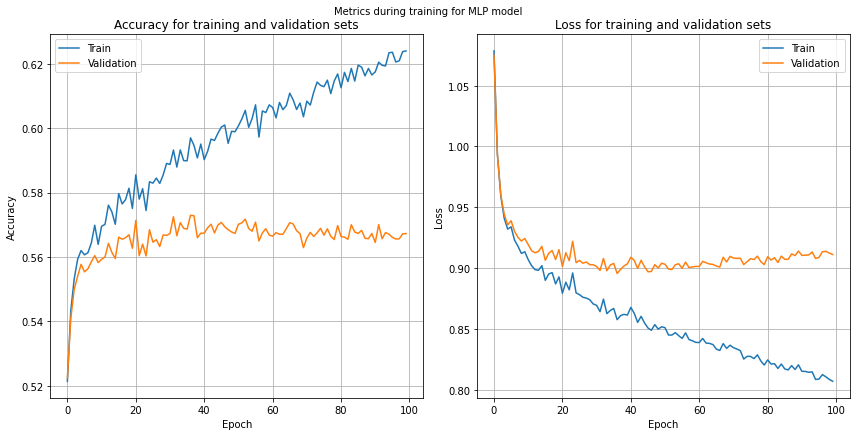

In [ ]:
mlp_train.plot_results('MLP model')

## Gated Recurrent Unit (GRU)

In [17]:
class GRU(nn.Module) : 
  def __init__(self, input_dim,embed_dim , hidden_dim, output_size,name = 'gru') : 
    super(GRU,self).__init__()
    self.checkpoint = name
    self.embed_dim = embed_dim
    self.embed = nn.Linear(input_dim, embed_dim)
    self.gru = nn.GRU(input_size = embed_dim , hidden_size = hidden_dim,num_layers=1, batch_first = True )
    self.out = nn.Linear(hidden_dim, output_size)

  def forward(self, x) :
    x = self.embed(x.float())
    x = x.view(-1, 1,self.embed_dim )
    gru_output , h_n = self.gru(x)
    out = self.out(gru_output)[:,-1,:]
    return out

  def save_checkpoint(self) :
      print('--- Save model checkpoint ---')
      torch.save(self.state_dict(), self.checkpoint)

  def load_checkpoint(self, gpu = True ) :

      print('--- Loading model checkpoint ---')
      if torch.cuda.is_available() and gpu :
          self.load_state_dict(torch.load(self.checkpoint))
      else :
          self.load_state_dict(torch.load(self.checkpoint,map_location=torch.device('cpu')))

In [ ]:
gru = GRU(input_dim=17, embed_dim = 128,hidden_dim=512, output_size=42, name = os.path.join('/content','models','gru'))

In [ ]:
params_gru = {
  'model' : gru,
  'df_train' : data_all_loader,
  'df_val' :  data_validation_loader,
  'optimizer' : optim.Adam,
  'criterion' : nn.CrossEntropyLoss(),
  'learning_rate' : 1e-3
}

In [ ]:
gru_train = Train(**params_gru)

In [ ]:
_ = gru_train.train(epochs = 50, show = True)

Epoch  0,                   Train: Loss=1.060, Accuracy=0.5270%,                   Validation: Loss=1.057, Accuracy=0.5271%
Epoch  5,                   Train: Loss=0.909, Accuracy=0.5646%,                   Validation: Loss=0.906, Accuracy=0.5650%
Epoch 10,                   Train: Loss=0.888, Accuracy=0.5761%,                   Validation: Loss=0.886, Accuracy=0.5754%
Epoch 15,                   Train: Loss=0.872, Accuracy=0.5841%,                   Validation: Loss=0.871, Accuracy=0.5836%
Epoch 20,                   Train: Loss=0.865, Accuracy=0.5890%,                   Validation: Loss=0.865, Accuracy=0.5881%
Epoch 25,                   Train: Loss=0.853, Accuracy=0.5936%,                   Validation: Loss=0.852, Accuracy=0.5928%
Epoch 30,                   Train: Loss=0.851, Accuracy=0.5977%,                   Validation: Loss=0.850, Accuracy=0.5969%
Epoch 35,                   Train: Loss=0.836, Accuracy=0.6085%,                   Validation: Loss=0.836, Accuracy=0.6081%
Epoch 40

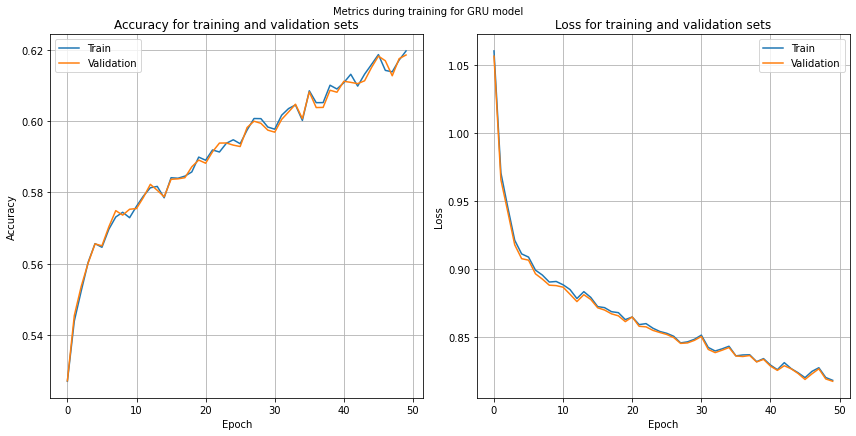

In [ ]:
gru_train.plot_results('GRU model')

# Random Forest 

## Hyperparameter tuning

In [103]:
# rf_clf = RandomForestClassifier()

# param = {
#     'n_estimators': [400,600],
#     'max_depth': [20, 40, 50],
# }

# grid_rfc = GridSearchCV(rf_clf, param_grid=param, cv=5)
# grid_rfc.fit(train_data, train_labels)

## Classifier with the best hyperparameters

In [8]:
# The random forest model with best hyperparameters 
rf_clf = RandomForestClassifier(n_estimators= 400, max_depth = 20) 

In [9]:
# The random forest model with best hyperparameters 
# rf_clf = RandomForestClassifier(**grid_rfc.best_params_) 

## Fit the training data

In [10]:
rf_clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
rf_preds = {'y_pred' : rf_clf.predict(validation_data), 'y_true' : validation_labels, 'y_proba' : rf_clf.predict_proba(validation_data)}

In [13]:
save_obj(rf_preds, 'rf_predictions')

In [15]:
rf_preds_test = {'y_test' : rf_clf.predict(np.array(pics_login)), 'y_test_proba' : rf_clf.predict_proba(np.array(pics_login))}

In [16]:
# Prediction on the testing set
save_obj(rf_preds_test, 'rf_predictions_test')

# 2. Group of frames

## Without noise 

### Functions to group the trames by group 

In [63]:
def stack_trames(data , N = 100) : 
  ''' Convert the trames into block of 100 '''
  n_trames = int(data.shape[0]/N)
  new_data  = []
  
  for i in range(n_trames - 1) : 
    new_data.append(data[N * i : N * (i+1)])

  return new_data

In [64]:
def stack_trames_labels(data : np.array, labels : np.array , N = 100) -> (np.array, np.array) : 
  ''' Convert the data into block of 100 '''
  letters = np.arange(42)
  new_data = []
  new_labels = []

  for letter in letters :     
    data_letter = data[np.where(labels == letter)[0]]
    new_letter = stack_trames(data_letter, N)

    new_data.extend(new_letter)
    new_labels.extend([letter for i in range(len(new_letter))]) 

  return np.array(new_data), np.array(new_labels) 

In [65]:
data_stack = {i : stack_trames_labels(data, labels, N = i) for i in [1,5, 10, 25, 50, 100, 200]}

### Function to plot mulitple curves 

In [66]:
def plot_multiple_curve_frame(gru_train_noise, name = 'GRU') : 
  figure, ax = plt.subplots(figsize = (10,8) , nrows=1,ncols=1)
  # ax = np.array(ax)
    
  for frame in gru_train_noise : 

    model = gru_train_noise[frame]
    accs = model.accuracies['Validation']
    ax.plot( accs , label = 'Frame {}'.format(frame), marker = '+')
  
  ax.grid(True)
  ax.legend()
  ax.set_title('Accuracy on validation sets for {}'.format(name))
  ax.set_xlabel('Epoch')
  plt.tight_layout()
  plt.show()

### Get training and validation data 

In [67]:
all_data_stack = {i : split_data(data_stack[i][0],data_stack[i][1] ) for i in data_stack}

In [68]:
# Data stack 
train_data_stack = {i : all_data_stack[i][0] for i in all_data_stack}
train_labels_stack = {i : all_data_stack[i][1] for i in all_data_stack}
validation_data_stack = {i : all_data_stack[i][2] for i in all_data_stack}
validation_labels_stack = {i : all_data_stack[i][3] for i in all_data_stack}


In [69]:
# Train data 
data_train_stack = {i : Pics_Dataset(train_data_stack[i], train_labels_stack[i]) for i in train_data_stack}
data_train_loader_stack = {i : DataLoader(data_train_stack[i], batch_size=500, shuffle=True) for i in data_train_stack}

# Validation data
data_validation_stack = {i : Pics_Dataset(validation_data_stack[i], validation_labels_stack[i]) for i in validation_data_stack}
data_validation_loader_stack = {i : DataLoader(data_validation_stack[i], batch_size=500, shuffle=True) for i in data_validation_stack}

# # All the data 
data_all_stack = {i : Pics_Dataset(data_stack[i][0], data_stack[i][1]) for i in data_stack}
data_all_loader_stack = {i : DataLoader(data_all_stack[i], batch_size=500, shuffle = True) for i in data_all_stack}


## Multi-layer Perceptron Stack (for group of frames)

In [70]:
class MLP_STACK(nn.Module) : 
  def __init__(self, input_dim, hidden_dim, output_size, name = 'mlp') : 
    super(MLP_STACK,self).__init__()
    self.checkpoint = name
    self.input_dim = input_dim
    self.fc1 = nn.Linear(17 * input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.out = nn.Linear(hidden_dim, output_size)

  def forward(self, x) :
    x = x.view(-1, 17 * self.input_dim)
    x = nn.ReLU()(self.fc1(x.float()))
    x = nn.ReLU()(self.fc2(x))
    x = self.out(x)
    return x

  def save_checkpoint(self) :
      print('--- Save model checkpoint ---')
      torch.save(self.state_dict(), self.checkpoint)

  def load_checkpoint(self, gpu = True ) :

      print('--- Loading model checkpoint ---')
      if torch.cuda.is_available() and gpu :
          self.load_state_dict(torch.load(self.checkpoint))
      else :
          self.load_state_dict(torch.load(self.checkpoint,map_location=torch.device('cpu')))

In [71]:
# Get a model for each group of frames 
mlp_stack = {i : MLP_STACK(input_dim = i , hidden_dim = 512 , output_size= 42, name =os.path.join('/content','models_stack','mlp_stack_'+str(i)) ) for i in all_data_stack}

In [72]:
params_mlp_stack = {i : {
  'model' : mlp_stack[i],\
  'df_train' : data_train_loader_stack[i],\
  'df_val' :  data_validation_loader_stack[i],\
  'optimizer' : optim.Adam,\
  'criterion' : nn.CrossEntropyLoss(),\
  'learning_rate' : 1e-3} for i in mlp_stack }

In [73]:
mlp_train_stack = { i :
    Train(**params_mlp_stack[i]) for i in params_mlp_stack}

In [74]:
# Train for each group of frames 
for i in mlp_train_stack : 
  _ = mlp_train_stack[i].train(epochs = 50, show = True )

Epoch  0,                   Train: Loss=0.998, Accuracy=0.5351%,                   Validation: Loss=0.997, Accuracy=0.5361%
Epoch  5,                   Train: Loss=0.914, Accuracy=0.5596%,                   Validation: Loss=0.919, Accuracy=0.5565%
Epoch 10,                   Train: Loss=0.887, Accuracy=0.5741%,                   Validation: Loss=0.898, Accuracy=0.5652%
Epoch 15,                   Train: Loss=0.873, Accuracy=0.5836%,                   Validation: Loss=0.892, Accuracy=0.5672%
Epoch 20,                   Train: Loss=0.856, Accuracy=0.5933%,                   Validation: Loss=0.885, Accuracy=0.5741%
Epoch 25,                   Train: Loss=0.844, Accuracy=0.5999%,                   Validation: Loss=0.885, Accuracy=0.5722%
Epoch 30,                   Train: Loss=0.835, Accuracy=0.6063%,                   Validation: Loss=0.891, Accuracy=0.5700%
Epoch 35,                   Train: Loss=0.827, Accuracy=0.6102%,                   Validation: Loss=0.897, Accuracy=0.5662%
Epoch 40

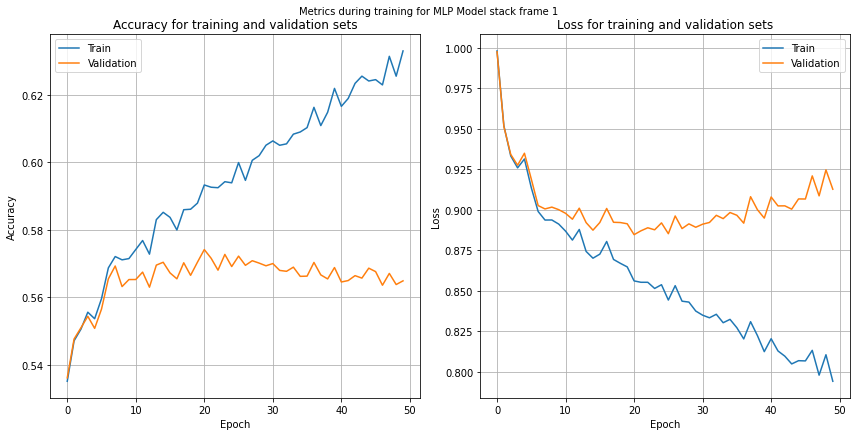

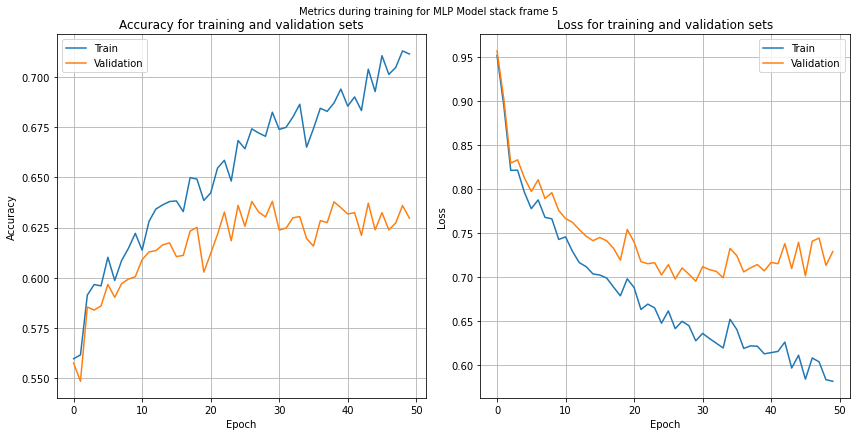

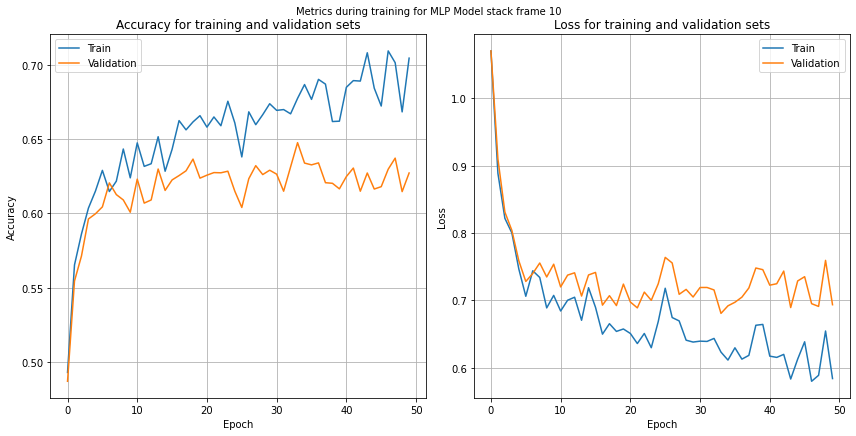

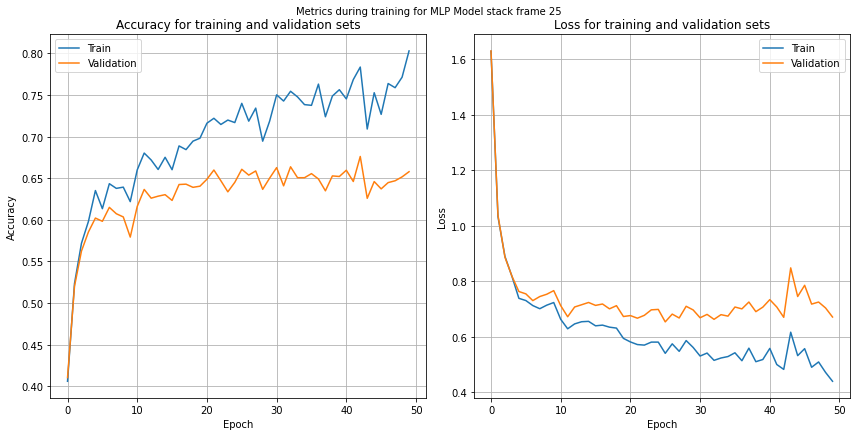

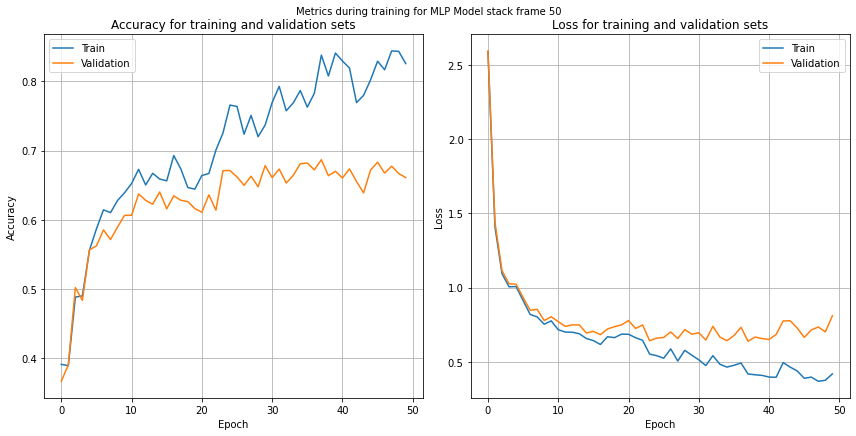

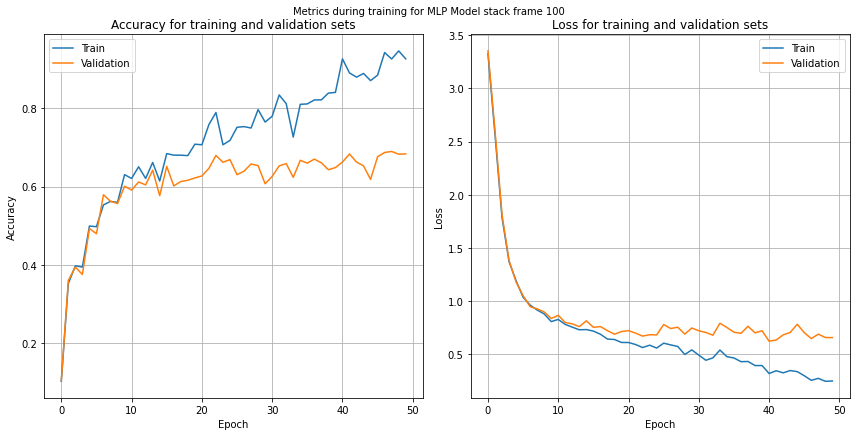

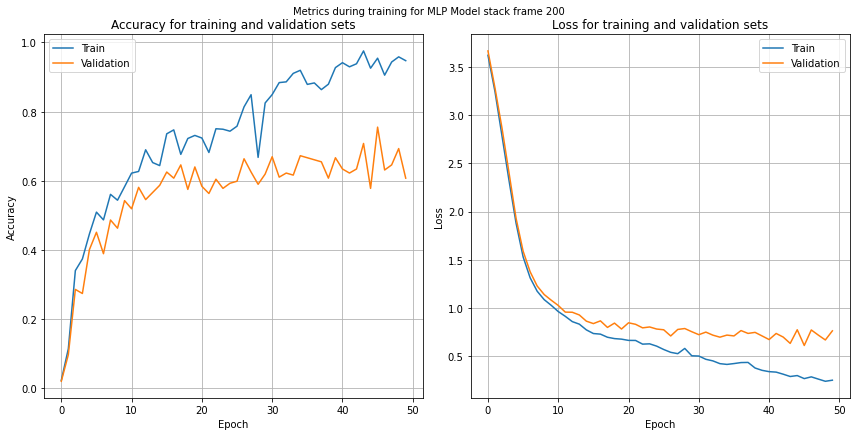

In [75]:
# Plot the results 
for i in mlp_train_stack : 
  mlp_train_stack[i].plot_results('MLP Model stack frame {}'.format(i))  

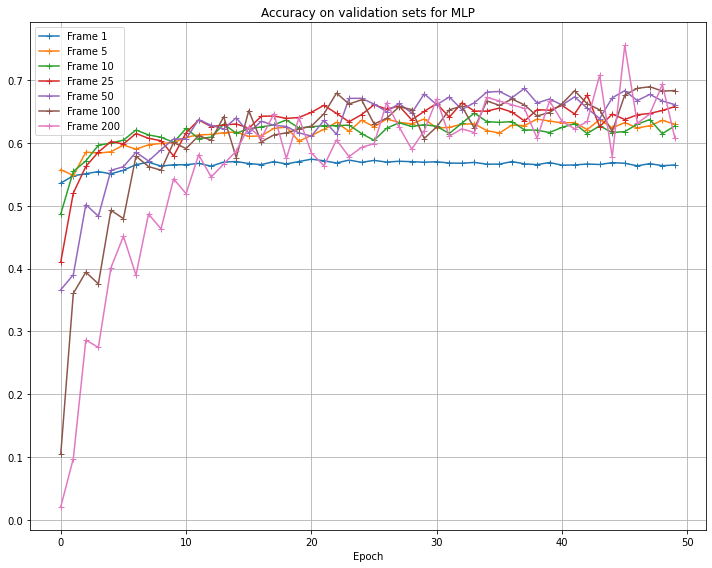

In [76]:
plot_multiple_curve_frame(mlp_train_stack, name = 'MLP') 

## GRU Stack (for group of frames)

In [77]:
class GRU_NOISE(nn.Module) : 
  def __init__(self, input_dim,embed_dim , hidden_dim, output_size, name = 'gru_noise') : 
    super(GRU_NOISE,self).__init__()
    self.checkpoint = os.path.join(os.getcwd(),name)
    self.embed_dim = embed_dim
    self.input_dim = input_dim
    self.gru = nn.GRU(input_size = input_dim , hidden_size = hidden_dim,num_layers=2, batch_first = True )
    self.out = nn.Linear(hidden_dim, output_size)

  def forward(self, x) :
    x = x.view(-1,  17 , self.input_dim)
    gru_output , h_n = self.gru(x.float())
    out = self.out(gru_output)[:,-1,:]
    return out

  def save_checkpoint(self) :
      print('--- Save model checkpoint ---')
      torch.save(self.state_dict(), self.checkpoint)

  def load_checkpoint(self, gpu = True ) :

      print('--- Loading model checkpoint ---')
      if torch.cuda.is_available() and gpu :
          self.load_state_dict(torch.load(self.checkpoint))
      else :
          self.load_state_dict(torch.load(self.checkpoint,map_location=torch.device('cpu')))

In [78]:
gru_model_stack = {i : GRU_NOISE(input_dim=i, embed_dim = None ,hidden_dim=256, output_size=42, name = \
                                 os.path.join('/content','models_stack','gru_stack_'+str(i))) for i in all_data_stack}

In [79]:
params_gru_stack = {i : {
  'model' : gru_model_stack[i],\
  'df_train' : data_train_loader_stack[i],\
  'df_val' :  data_validation_loader_stack[i],\
  'optimizer' : optim.Adam,\
  'criterion' : nn.CrossEntropyLoss(),\
  'learning_rate' : 1e-3} for i in gru_model_stack }

In [80]:
gru_train_stack = {
    i : Train(**params_gru_stack[i]) for i in params_gru_stack
}

In [81]:
for width in gru_train_stack : 
  _ = gru_train_stack[width].train(epochs = 50, show = True)

Epoch  0,                   Train: Loss=1.197, Accuracy=0.4859%,                   Validation: Loss=1.194, Accuracy=0.4891%
Epoch  5,                   Train: Loss=0.895, Accuracy=0.5643%,                   Validation: Loss=0.899, Accuracy=0.5601%
Epoch 10,                   Train: Loss=0.876, Accuracy=0.5747%,                   Validation: Loss=0.891, Accuracy=0.5676%
Epoch 15,                   Train: Loss=0.853, Accuracy=0.5875%,                   Validation: Loss=0.888, Accuracy=0.5681%
Epoch 20,                   Train: Loss=0.821, Accuracy=0.6119%,                   Validation: Loss=0.891, Accuracy=0.5667%
Epoch 25,                   Train: Loss=0.782, Accuracy=0.6398%,                   Validation: Loss=0.909, Accuracy=0.5665%
Epoch 30,                   Train: Loss=0.734, Accuracy=0.6731%,                   Validation: Loss=0.945, Accuracy=0.5572%
Epoch 35,                   Train: Loss=0.678, Accuracy=0.7071%,                   Validation: Loss=0.992, Accuracy=0.5531%
Epoch 40

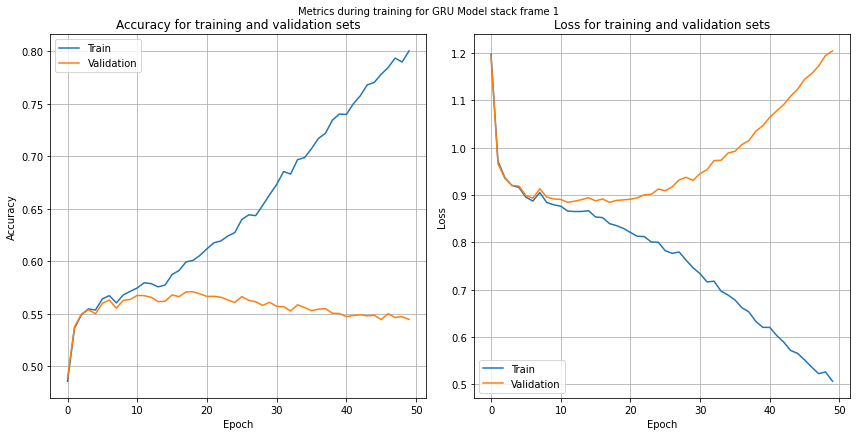

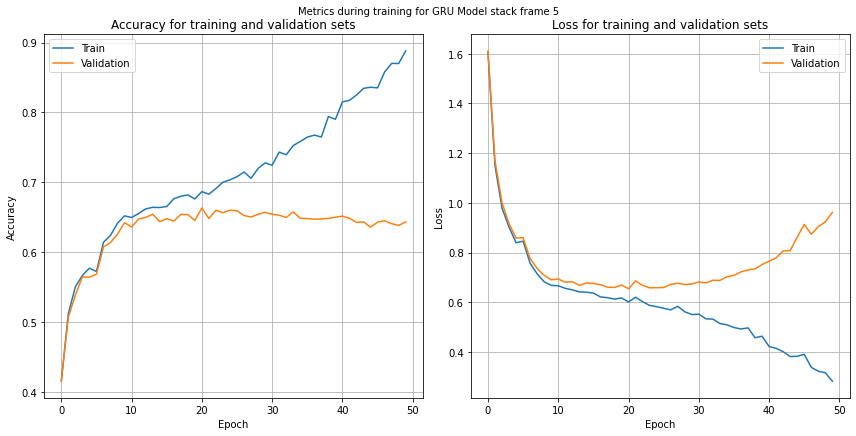

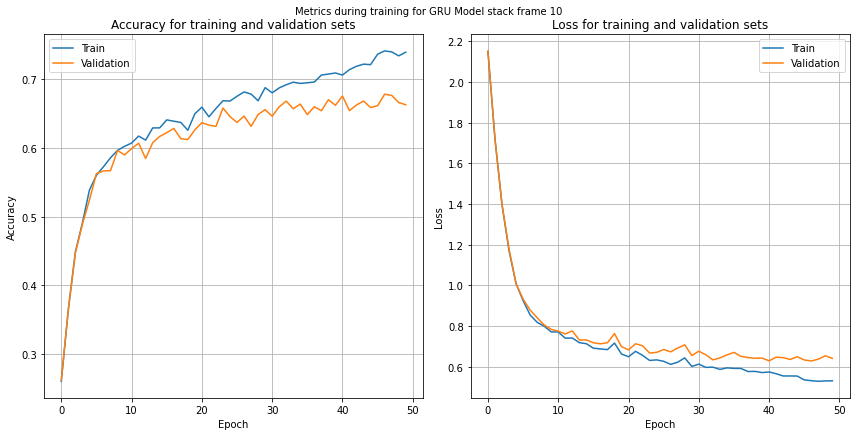

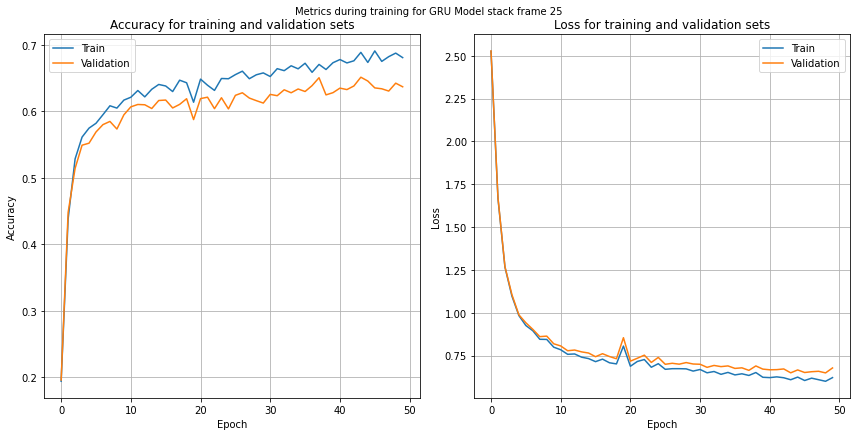

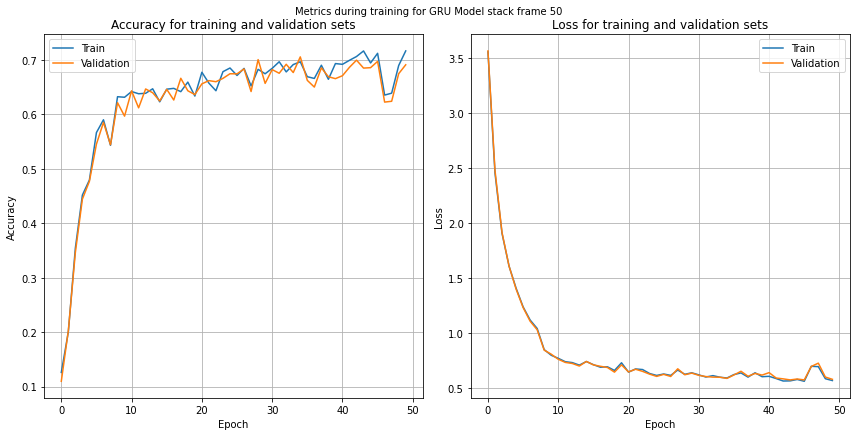

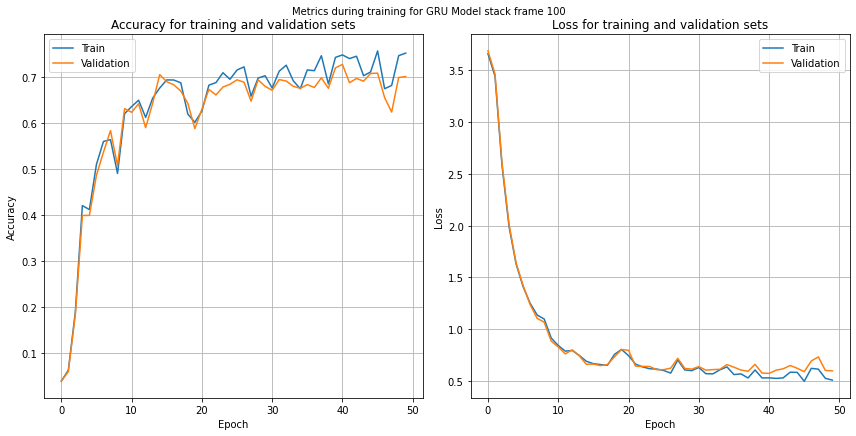

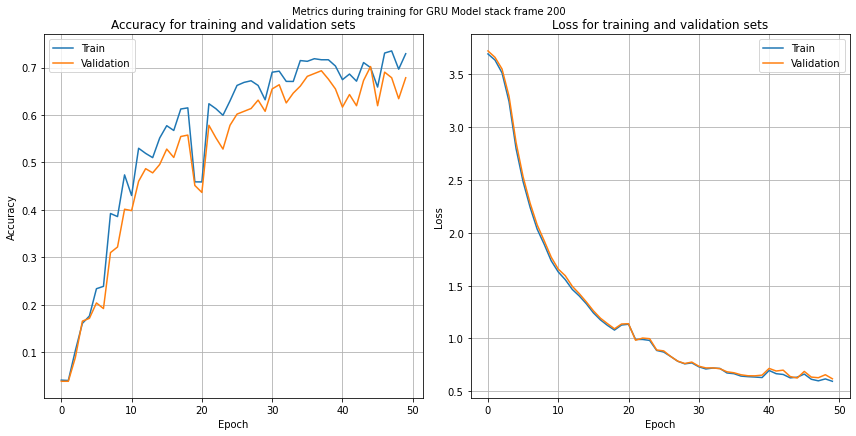

In [82]:
for i in gru_train_stack : 
  gru_train_stack[i].plot_results('GRU Model stack frame {}'.format(i))  

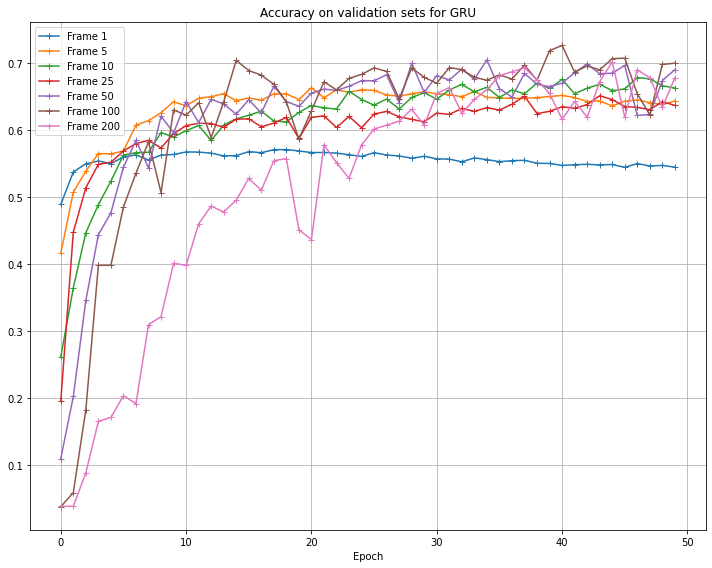

In [83]:
plot_multiple_curve_frame(gru_train_stack, name = 'GRU') 

## With noise 

### Functions that create noise

- The noise is added in this way : 
    - For each label: 
          -  Select a frame with the given label
          - Choose another label C times (C is a hyperparameter)
          - Mix the label with the new frame as follows : 
            - With probability 0.25, do the average 
            - With probability 0.25, do the difference and divide by 2 
            - With probability 0.25, do the product of the frames   
            - With probability 0.25, do the sum of the trame

In [84]:
def create_noise_frames(trame_a, trame_b, N = 25) : 
  ''' Create noise from the trame b into the trame a 
      N is the number of frames from b that goes into trame a 
  '''
  c = np.random.uniform()
  if  c < 0.25 : 
    return (trame_a + trame_b)/2
  elif c < 0.5 : 
    return (trame_a - trame_b)/2
  elif c < 0.75 : 
    return (trame_a * trame_b)
  else : 
    return (trame_a + trame_b)

In [85]:
def add_noise(data : np.array, labels : np.array, coeff : int , n_frames : int ,p = 0.25 )  -> (np.array, np.array) : 
  ''' Add noise in the trames '''
  new_data = list(data)
  new_labels = list(labels)
  augmentation = int(coeff * len(new_data))
  # Number of frames with noise 
  N = int(p * n_frames)
  for letter in np.arange(42) : 
    # Take c times the trame from a label and add noise with other caracters 
    data_letter = data[np.where(labels == letter)[0]]
    for c in range(coeff) : 
      # ADD NOISE 
      data_c = data[np.where(labels == letter)[0]]
      index_c = np.random.choice(np.arange(len(data_c)))
      current_data = data[index_c]
      # Get trames from other caracters
      letter_new = np.random.choice([i for i in range(42) if i!=letter])
      trames_new = data[np.where(labels == letter_new)[0]]
      index_new = np.random.choice(np.arange(len(trames_new)))
      trame_to_add = trames_new[index_new]

      new_trame = create_noise_frames(current_data, trame_to_add, N = N)
      new_data.append(new_trame)
      new_labels.append(letter)
  return np.array(new_data), np.array(new_labels) 

In [86]:
data_stack = {i : stack_trames_labels(data, labels, N = i) for i in [1,5, 10, 25, 50, 100, 200]}

In [87]:
data_noise = {i : add_noise( data_stack[i][0], data_stack[i][1], coeff = 100, n_frames = i  ) for i in data_stack}

In [88]:
all_data_noise = {i : split_data(data_noise[i][0],data_noise[i][1] ) for i in data_noise}

In [89]:
# Split into training and validation sets 
train_data_noise = {i : all_data_noise[i][0] for i in all_data_noise}
train_labels_noise = {i : all_data_noise[i][1] for i in all_data_noise}
validation_data_noise = {i : all_data_noise[i][2] for i in all_data_noise}
validation_labels_noise = {i : all_data_noise[i][3] for i in all_data_noise}

### Create pytorch dataset 

In [90]:
# Train data 
data_train_noise = {i : Pics_Dataset(train_data_noise[i], train_labels_noise[i]) for i in train_data_noise}
data_train_loader_noise = {i : DataLoader(data_train_noise[i], batch_size=500, shuffle=True) for i in data_train_noise}

# Validation data
data_validation_noise = {i : Pics_Dataset(validation_data_noise[i], validation_labels_noise[i]) for i in validation_data_noise}
data_validation_loader_noise = {i : DataLoader(data_validation_noise[i], batch_size=500, shuffle=True) for i in data_validation_noise}

# All the data 
data_all_noise = {i : Pics_Dataset(data_noise[i][0], data_noise[i][1]) for i in data_noise}
data_all_loader_noise = {i : DataLoader(data_all_noise[i], batch_size=500, shuffle = True) for i in data_all_noise}

## MLP Model noise

In [91]:
mlp_noise = {i : MLP_STACK(input_dim = i , hidden_dim = 512 , output_size= 42, name =os.path.join('/content','models_noise','mlp_noise_'+str(i))) for i in all_data_noise}

In [92]:
params_mlp_noise = {i : {
  'model' : mlp_noise[i],\
  'df_train' : data_train_loader_noise[i],\
  'df_val' :  data_validation_loader_noise[i],\
  'optimizer' : optim.Adam,\
  'criterion' : nn.CrossEntropyLoss(),\
  'learning_rate' : 1e-3} for i in mlp_noise }

In [93]:
mlp_train_noise = { i :
    Train(**params_mlp_noise[i]) for i in params_mlp_noise}

In [94]:
for i in mlp_train_noise : 
  _ = mlp_train_noise[i].train(epochs = 50, show = True )

Epoch  0,                   Train: Loss=1.098, Accuracy=0.5250%,                   Validation: Loss=1.103, Accuracy=0.5182%
Epoch  5,                   Train: Loss=0.968, Accuracy=0.5568%,                   Validation: Loss=0.985, Accuracy=0.5454%
Epoch 10,                   Train: Loss=0.932, Accuracy=0.5691%,                   Validation: Loss=0.955, Accuracy=0.5578%
Epoch 15,                   Train: Loss=0.913, Accuracy=0.5791%,                   Validation: Loss=0.948, Accuracy=0.5616%
Epoch 20,                   Train: Loss=0.897, Accuracy=0.5877%,                   Validation: Loss=0.947, Accuracy=0.5596%
Epoch 25,                   Train: Loss=0.890, Accuracy=0.5914%,                   Validation: Loss=0.951, Accuracy=0.5585%
Epoch 30,                   Train: Loss=0.884, Accuracy=0.5931%,                   Validation: Loss=0.963, Accuracy=0.5520%
Epoch 35,                   Train: Loss=0.860, Accuracy=0.6086%,                   Validation: Loss=0.954, Accuracy=0.5587%
Epoch 40

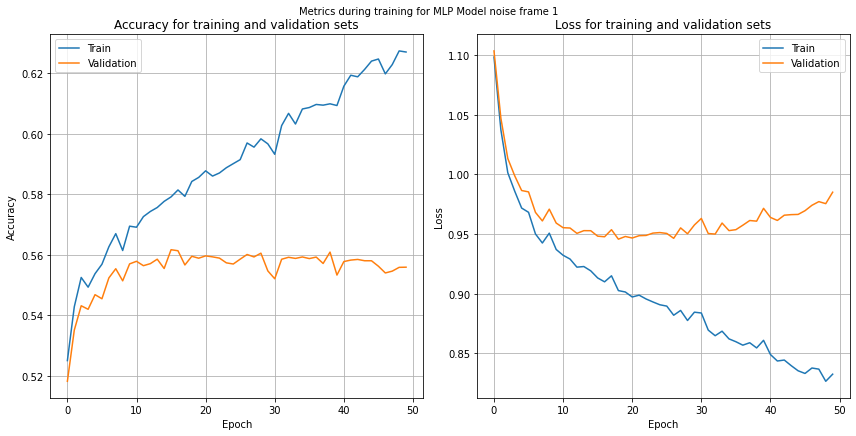

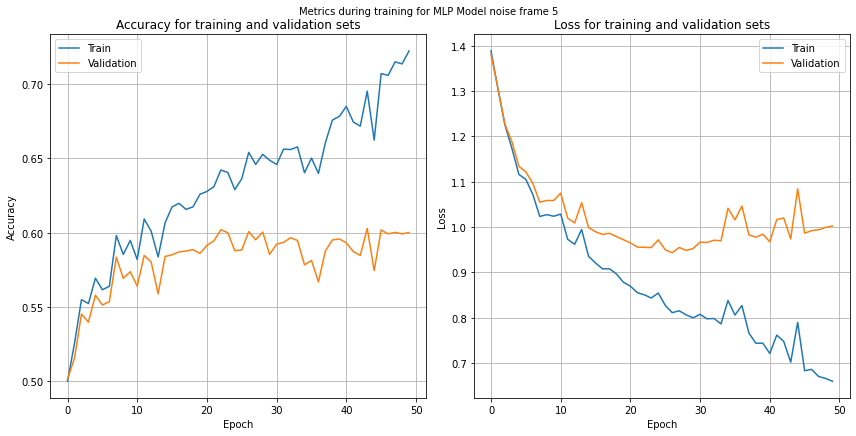

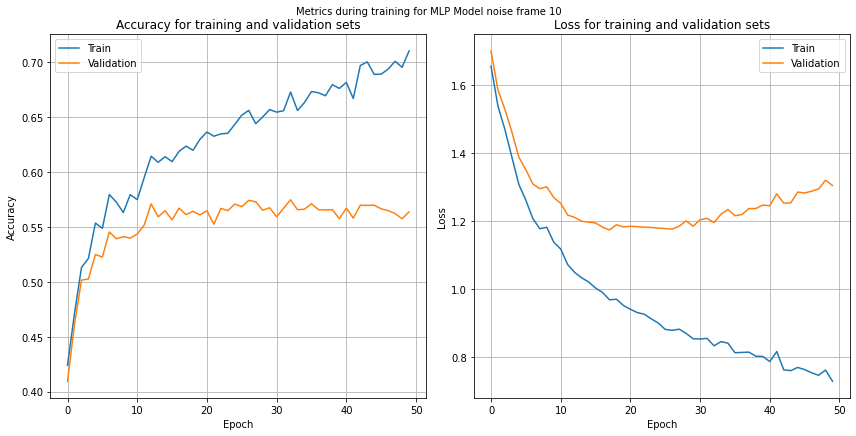

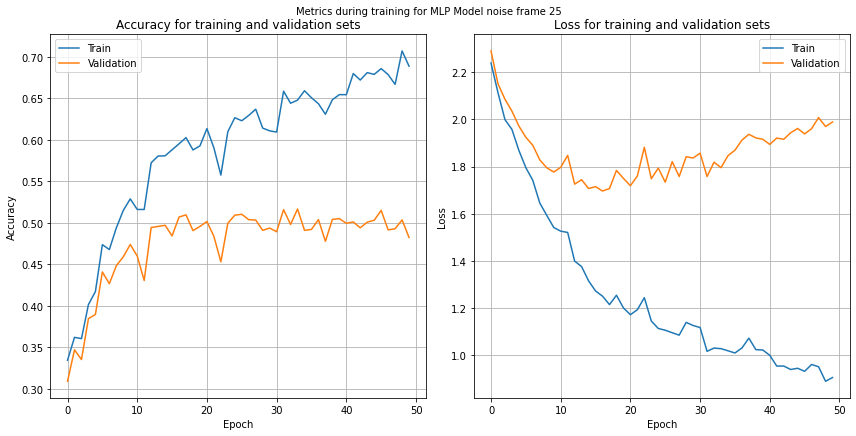

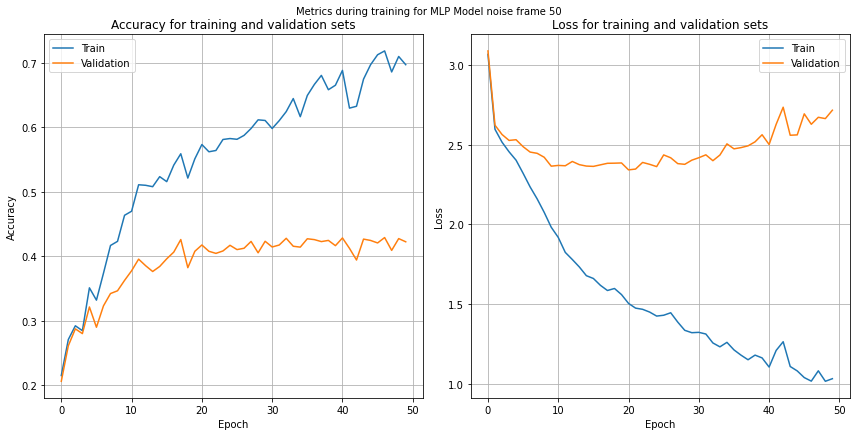

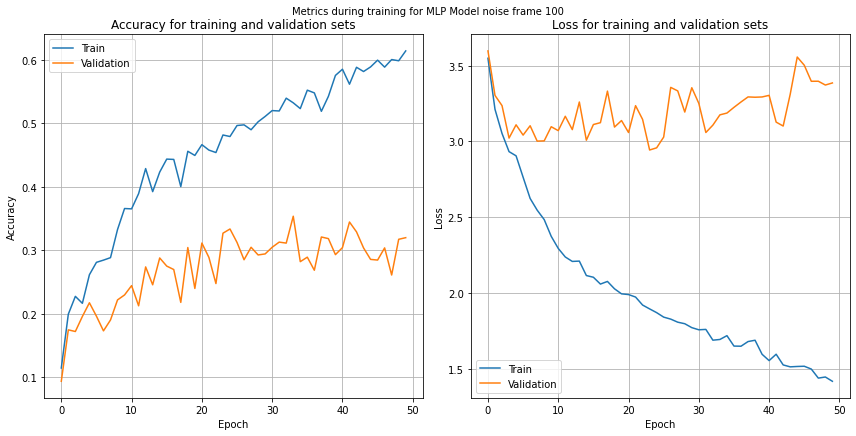

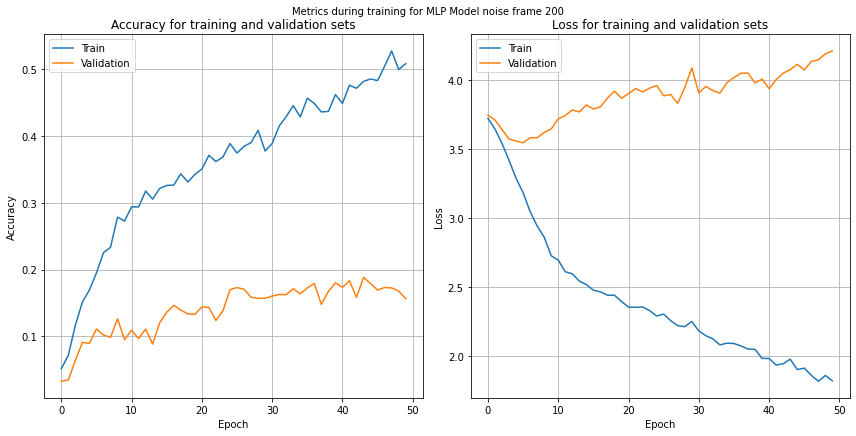

In [95]:
for i in mlp_train_noise : 
  mlp_train_noise[i].plot_results('MLP Model noise frame {}'.format(i))  

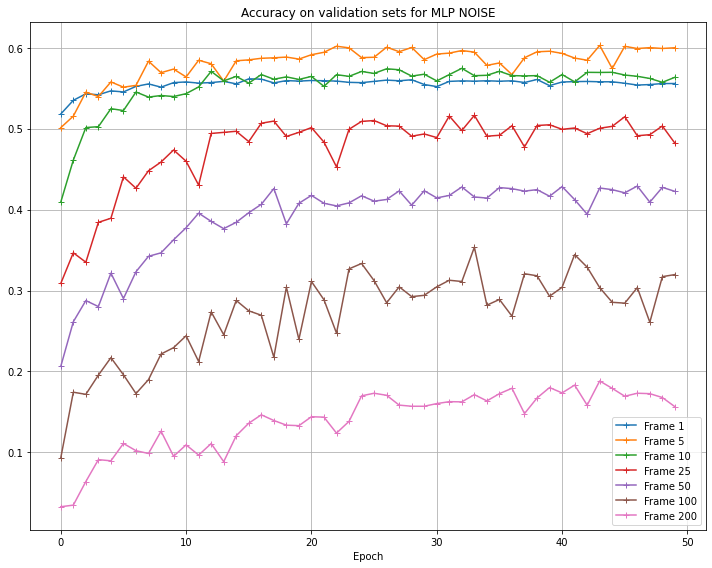

In [96]:
plot_multiple_curve_frame(mlp_train_noise, name = 'MLP NOISE')

## GRU Noise


In [97]:
gru_model_noise = {i : GRU_NOISE(input_dim=i, embed_dim = None ,hidden_dim=256, output_size=42, name =\
                                 os.path.join('/content','models_noise','gru_noise_'+str(i))) for i in all_data_noise}

In [98]:
params_gru_noise = {i : {
  'model' : gru_model_noise[i],\
  'df_train' : data_train_loader_noise[i],\
  'df_val' :  data_validation_loader_noise[i],\
  'optimizer' : optim.Adam,\
  'criterion' : nn.CrossEntropyLoss(),\
  'learning_rate' : 1e-3} for i in gru_model_noise }

In [99]:
gru_train_noise = {
    i : Train(**params_gru_noise[i]) for i in params_gru_noise
}

In [100]:
for width in gru_train_noise : 
  _ = gru_train_noise[width].train(epochs = 50, show = True)

Epoch  0,                   Train: Loss=1.205, Accuracy=0.4936%,                   Validation: Loss=1.212, Accuracy=0.4877%
Epoch  5,                   Train: Loss=0.940, Accuracy=0.5570%,                   Validation: Loss=0.953, Accuracy=0.5487%
Epoch 10,                   Train: Loss=0.914, Accuracy=0.5679%,                   Validation: Loss=0.941, Accuracy=0.5535%
Epoch 15,                   Train: Loss=0.892, Accuracy=0.5827%,                   Validation: Loss=0.939, Accuracy=0.5569%
Epoch 20,                   Train: Loss=0.859, Accuracy=0.6048%,                   Validation: Loss=0.947, Accuracy=0.5559%
Epoch 25,                   Train: Loss=0.834, Accuracy=0.6204%,                   Validation: Loss=0.975, Accuracy=0.5484%
Epoch 30,                   Train: Loss=0.764, Accuracy=0.6672%,                   Validation: Loss=1.000, Accuracy=0.5487%
Epoch 35,                   Train: Loss=0.695, Accuracy=0.7095%,                   Validation: Loss=1.054, Accuracy=0.5448%
Epoch 40

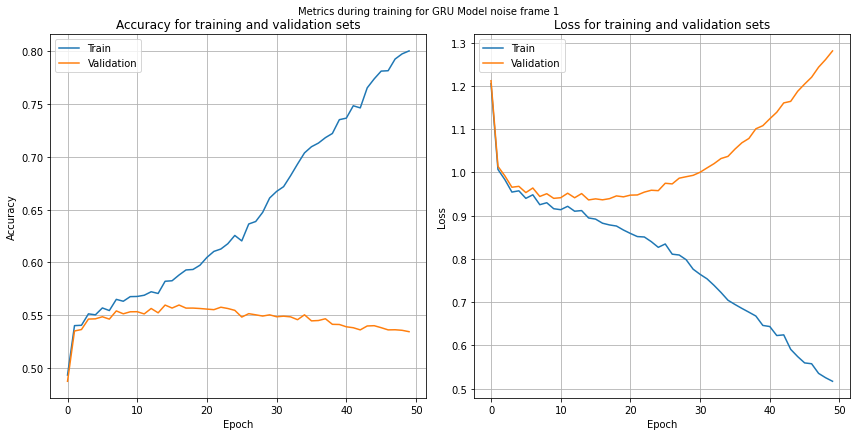

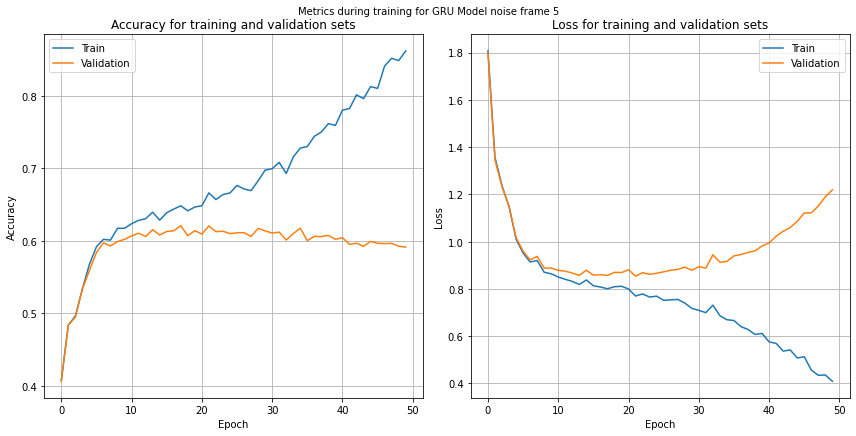

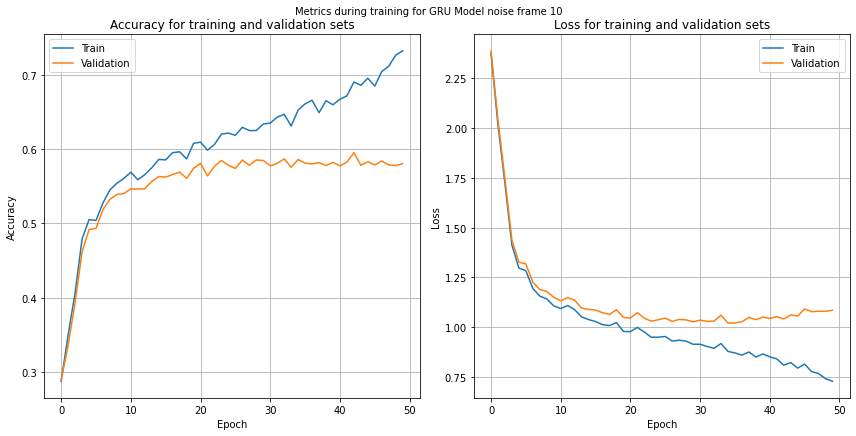

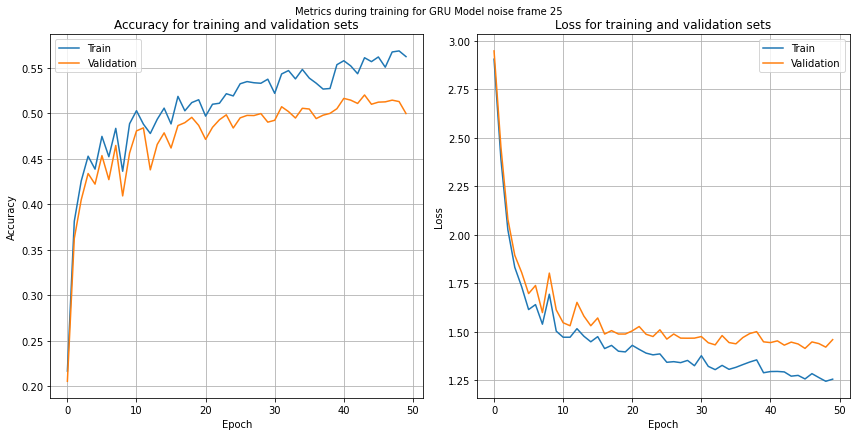

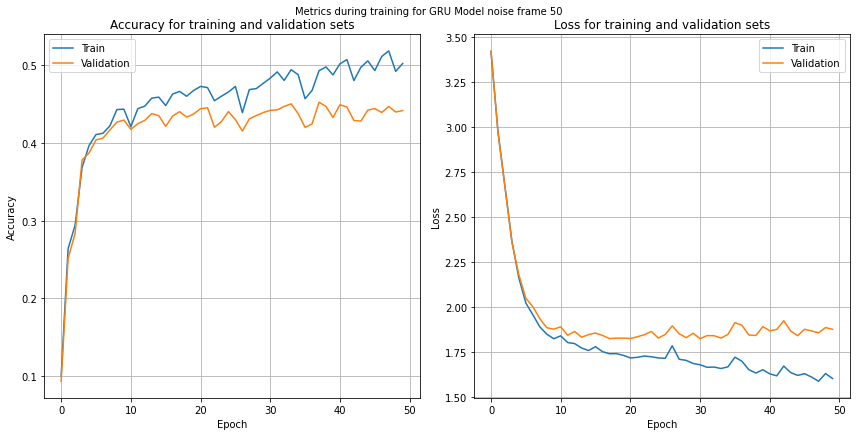

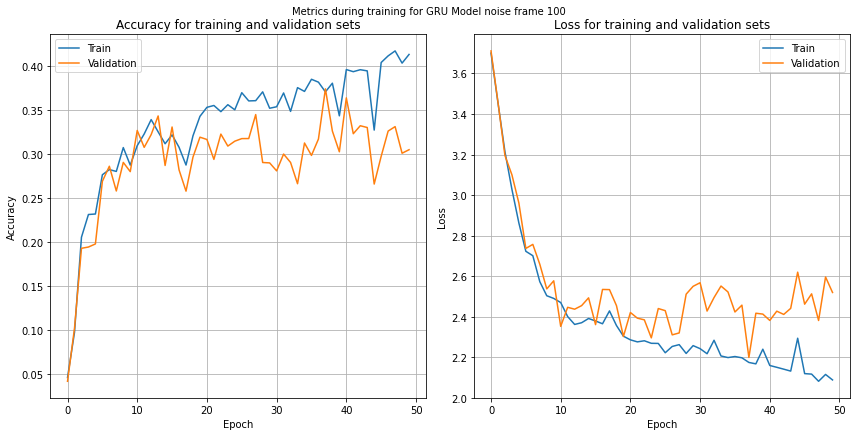

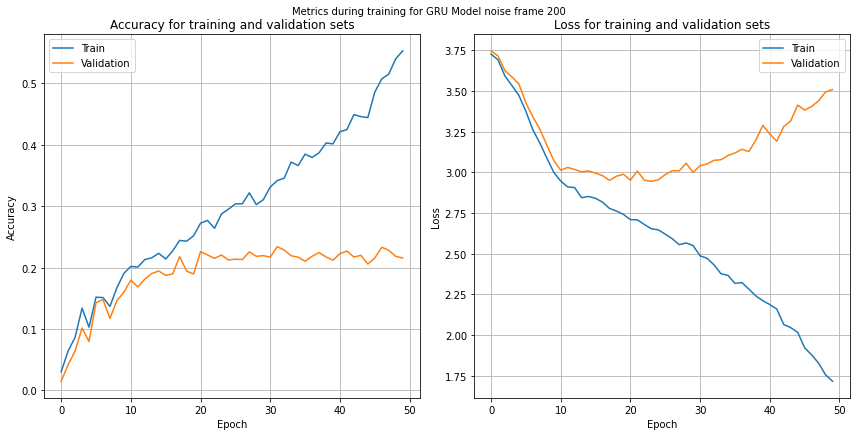

In [101]:
for i in gru_train_noise : 
  gru_train_noise[i].plot_results('GRU Model noise frame {}'.format(i))  

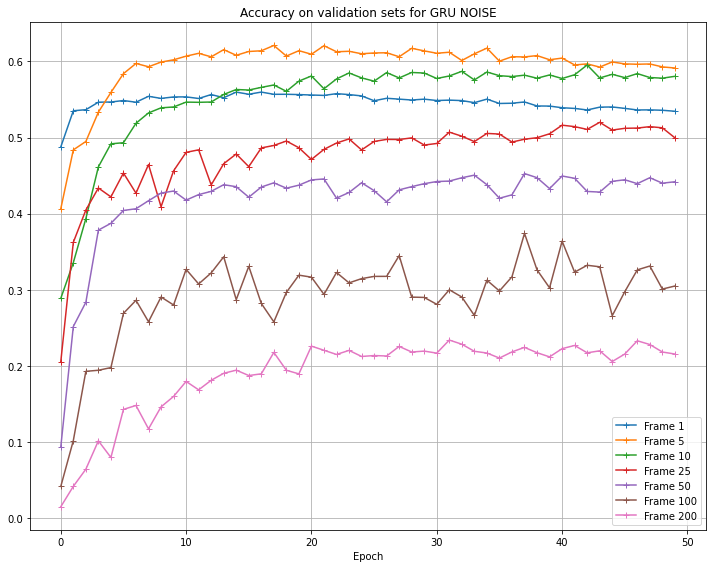

In [102]:
plot_multiple_curve_frame(gru_train_noise, name = 'GRU NOISE')